# SVM Quadratic Programming Example

In the quadratic programming problem, we aim to find $\textbf{x}$ satisfying
$$ \begin{array}{rl} \text{min}_{\textbf{x}} & \frac{1}{2}\textbf{x}^\top \texttt{Q} \textbf{x} + \textbf{c}^\top\textbf{x} \\ \text{subject to} & \texttt{A}\textbf{x} \le \textbf{b} \\
& \texttt{E}\textbf{x} = \textbf{d} .\end{array}$$

We can use cvxopt packages in Python as follows. I'm using a little wrappers from
[this nice blog about QP in Python](https://scaron.info/blog/quadratic-programming-in-python.html).

To install on Ubuntu, you'll want to do

    % pip3 install cvxopt

## A wrapper for cvxopt

Once cvxopt is installed, we can define a function `cvxopt_solv_qp()` to find $\textbf{x}^*$:

In [1]:
import numpy as np
import cvxopt

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))

Note that cvxopt uses its own data type for the matrix inputs, so we have to convert the numpy matrices to cvxopt matrices.

## Example problem

Anyway, given this solver function, let's try to solve a simple example such as the one from the blog mentioned above:

$$\begin{array}{rl} \min_{\textbf{x}} & \left\| \begin{bmatrix} 1 & 2 & 0 \\ -8 & 3 & 2 \\ 0 & 1 & 1 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix}-\begin{bmatrix} 3 \\ 2 \\ 3 \end{bmatrix} \right\|^2 \\
\text{subject to} & \begin{bmatrix} 1 & 2 & 1 \\ 2 & 0 & 1 \\ -1 & 2 & -1 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} \le \begin{bmatrix} 3 \\ 2 \\ -2 \end{bmatrix} \end{array} $$

In [2]:
# Convert problem to standard representation 1/2 x.T Q x + c.T x s.t A x <= b
# and solve with cvxopt

M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
Q = M.T @ M
c = (np.array([3., 2., 3.]) @ M).reshape((3,))
A = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
b = np.array([3., 2., -2.]).reshape((3,))

print("Cvxopt solution:")
cvxopt_solve_qp(Q, c, A, b)

Cvxopt solution:
     pcost       dcost       gap    pres   dres
 0: -3.2822e+00 -9.6005e+00  6e+00  5e-17  9e-01
 1: -6.9907e+00 -8.3734e+00  1e+00  3e-16  3e-01
 2: -1.0434e+01 -1.1566e+01  1e+00  2e-16  5e-16
 3: -1.0492e+01 -1.0506e+01  1e-02  2e-16  5e-16
 4: -1.0495e+01 -1.0495e+01  1e-04  2e-16  3e-16
 5: -1.0495e+01 -1.0495e+01  1e-06  3e-16  2e-16
Optimal solution found.


array([-0.49025721, -1.57755278, -0.66484775])

## Example of finding the maximum margin hyperplane

OK, now let's try to use cvxopt to find the maximum margin hyperplane separating two classes.

Suppose we want to predict whether a person is male or female based on their height and weight.

I generated some fake data for heights and weights and planted 3 points to force a maximum margin hyperplane of

$$\mathbf{w}^* = \begin{bmatrix} 0.64018 \\ 0.76822 \end{bmatrix} \; \; \; b^* = -153.32 .$$

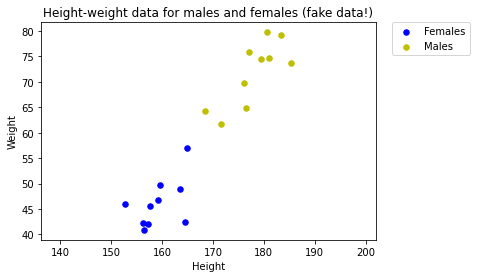

In [3]:
import matplotlib.pyplot as plt

Xf = np.matrix([[ 164.939, 163.431, 157.554, 152.785, 156.385, 159.242, 156.281, 164.411, 157.308, 159.579 ],
                [  56.927,  48.945,  45.678,  45.969,  40.896,  46.848,  42.225,  42.380,  42.150,  49.739 ]]).T;
Xm = np.matrix([[ 168.524, 171.597, 179.469, 176.063, 180.939, 177.011, 183.284, 180.549, 176.502, 185.392 ],
                [  64.353,  61.793,  74.552,  69.851,  74.730,  75.871,  79.170,  79.753,  64.923,  73.665 ]]).T;
X = np.concatenate([Xf, Xm],0);
y = np.concatenate([-np.matrix(np.ones([10,1])),np.matrix(np.ones([10,1]))]);

def plot_mf(Xf,Xm):
    axes = plt.axes()
    females_series = plt.scatter(np.array(Xf[:,0]), np.array(Xf[:,1]), s=30, c='b', marker='o', label='Females')
    males_series = plt.scatter(np.array(Xm[:,0]), np.array(Xm[:,1]), s=30, c='y', marker='o', label='Males')
    axes.set_aspect('equal', 'datalim')
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.title('Height-weight data for males and females (fake data!)')
    plt.legend(handles=[females_series, males_series], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return axes

axes = plot_mf(Xf,Xm)

We now know that the SVM optimization problem in the linearly separable case is to
find $\mathbf{w},b$ satisfying
$$ \begin{array}{rl} \min_{\mathbf{w},b} & \|\mathbf{w}\| \\
                     \text{subject to} & y^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)}+b)\ge 1, i \in 1..m
   \end{array}
$$

Hopefully you can see that to cast this problem as a QP problem, for the objective function, we just let
$$ \mathtt{Q} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{bmatrix} \; \; \;
   \mathbf{c} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix} $$

$$\mathtt{A} = \begin{bmatrix} -y^{(1)}\mathbf{x}^{(1)\top} & -y^{(1)} \\
                               -y^{(2)}\mathbf{x}^{(2)\top} & -y^{(2)} \\
                               \vdots & \vdots \end{bmatrix} \;\;\;
  \mathbf{b} = \begin{bmatrix} -1 \\ -1 \\ \vdots \end{bmatrix} $$

Next we use cvxopt to find the optimal w and b:

In [4]:
Q = np.eye(3);
Q[2,2] = 0;
c = np.zeros([3])
A = np.multiply(np.tile(-y,[1, 3]), np.concatenate([X, np.ones([20,1])],1))
b = -np.ones([20])
x = cvxopt_solve_qp(Q, c, A, b);
w = np.matrix([[x[0]],[x[1]]]);
b = x[2];
scale = np.linalg.norm(w);
w = w / scale;
b = b / scale;
print('Optimal w: [%f %f] b: %f' % (w[0,0],w[1,0],b));

     pcost       dcost       gap    pres   dres
 0:  1.4721e-03  6.5053e+00  5e+01  2e+00  4e+02
 1:  1.0012e-02 -4.7161e+00  1e+01  6e-01  1e+02
 2:  2.6180e-02 -4.8172e+00  7e+00  2e-01  6e+01
 3:  3.9767e-02 -4.5363e-01  5e-01  1e-02  2e+00
 4:  3.5404e-02  1.8200e-02  2e-02  5e-15  9e-14
 5:  3.1392e-02  3.0877e-02  5e-04  5e-15  6e-13
 6:  3.1250e-02  3.1245e-02  5e-06  6e-15  2e-13
 7:  3.1249e-02  3.1248e-02  5e-08  5e-15  2e-13
Optimal solution found.
Optimal w: [0.640061 0.768324] b: -153.309495


Now let's plot $\mathbf{w}$ and $b$ with the data:

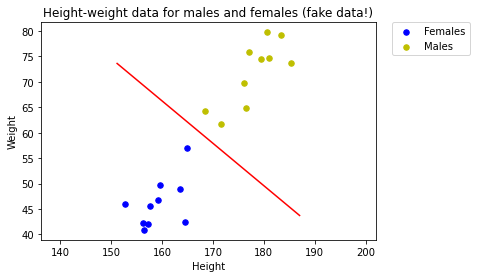

In [5]:
def plot_w(w, b, axes):
    ylim = axes.get_ylim()
    xlim = axes.get_xlim()
    p1 = (xlim[0], - (w[0,0] * xlim[0] + b) / w[1,0])
    p2 = (xlim[1], - (w[0,0] * xlim[1] + b) / w[1,0])
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'r-')

axes = plot_mf(Xf, Xm)
plot_w(w, b, axes)